# Deep Learning Project – Sports Image Classification

## **PHASE 1**

## **1. All the Libraries Needed**


In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from torch.utils.tensorboard import SummaryWriter
import os, datetime
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import threading
import time
from pyngrok import ngrok
from tensorboard import notebook


## **2. Load and Explore the Data**

In [2]:
train_df = pd.read_csv('/kaggle/input/sport-classification/train.csv')
test_df = pd.read_csv('/kaggle/input/sport-classification/test.csv')

In [3]:
print(train_df.head())


         image_ID      label
0  7c225f7b61.jpg  Badminton
1         b31.jpg  Badminton
2  acb146546c.jpg  Badminton
3  0e62f4d8f2.jpg  Badminton
4  cfd2c28c74.jpg    Cricket


In [4]:
train_df['label'].value_counts()

label
Cricket      1556
Wrestling    1471
Tennis       1445
Badminton    1394
Soccer       1188
Swimming      595
Karate        578
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Labels in Training Set')

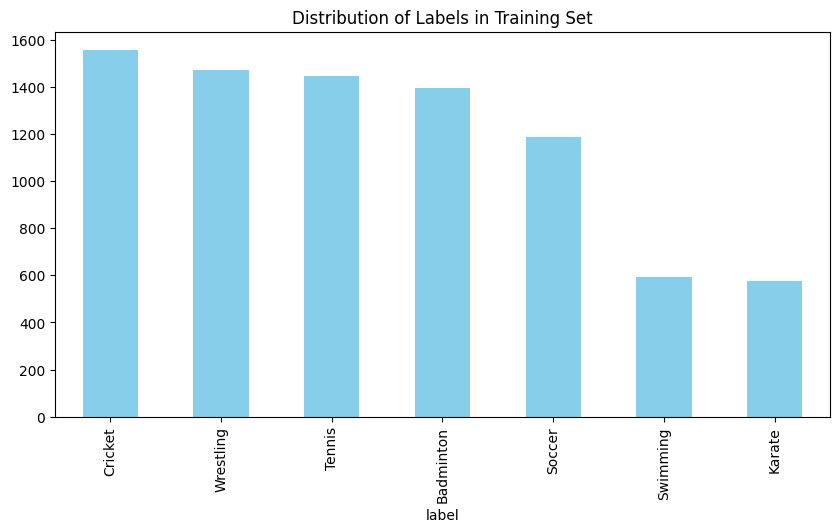

In [5]:
train_df['label'].value_counts().plot(kind='bar', figsize=(10, 5), color='skyblue')
plt.title('Distribution of Labels in Training Set')

In [6]:
train_df.tail()

,image_ID,label
8222,903d2fffb3.jpg,Cricket
8223,b5f174c688.jpg,Badminton
8224,2433770a67.jpg,Tennis
8225,6403964166.jpg,Tennis
8226,f07f00564e.jpg,Swimming


In [7]:
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8227 entries, 0 to 8226
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_ID  8227 non-null   object
 1   label     8227 non-null   object
dtypes: object(2)
memory usage: 128.7+ KB


,image_ID,label
count,8227,8227
unique,8227,7
top,f07f00564e.jpg,Cricket
freq,1,1556


## **3. Clean the Data**

In [8]:
print(train_df.isnull().sum())
train_df.drop_duplicates(inplace=True)

image_ID    0
label       0
dtype: int64


## **4. Visualize the Class Distribution**

Text(0.5, 1.0, 'Distribution of Sports Classes')

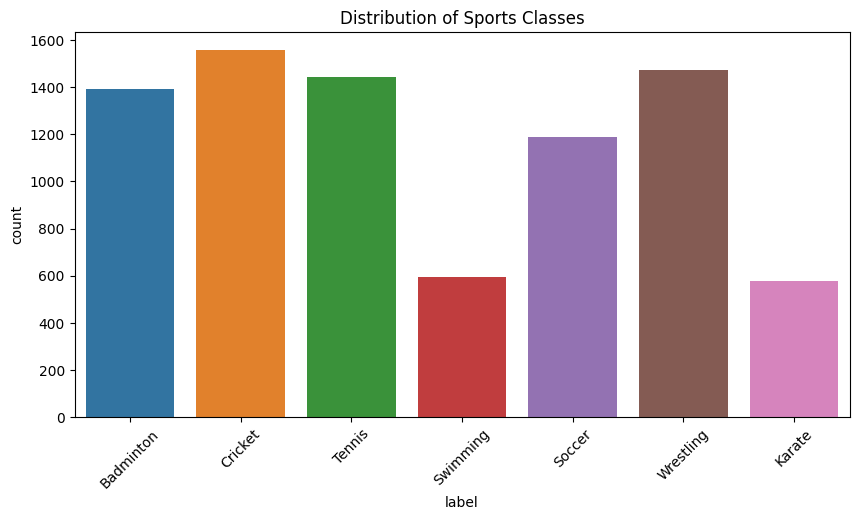

In [9]:
plt.figure(figsize=(10,5))
sns.countplot(data=train_df, x='label')
plt.xticks(rotation=45)
plt.title("Distribution of Sports Classes")

## **5. Encode the Labels**

In [10]:
le = LabelEncoder()
train_df['encoded_label'] = le.fit_transform(train_df['label'])
classes = le.classes_

## **6. Preprocess the Images for Training**

In [97]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


## **PHASE 2**

## **Setup TensorBoard Logging**

In [12]:
logdir = os.path.join("runs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(logdir)
print(f"Logging to {logdir}")

Logging to runs/20250502-194329


## **Training and Evaluation Functions**

In [13]:
from google.colab import drive
drive.mount('/content/drive')

NotImplementedError: Mounting drive is unsupported in this environment. Use PyDrive instead. See examples at https://colab.research.google.com/notebooks/io.ipynb#scrollTo=7taylj9wpsA2.

In [56]:
class SportsDataset(Dataset):
    def __init__(self, dataframe=None, img_dir="", transform=None, test_mode=False):
        self.df = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.test_mode = test_mode

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['image_ID']
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        if self.test_mode:
            return image, img_name  # no label
        else:
            label = self.df.iloc[idx]['encoded_label']
            return image, label


In [57]:
train_dataset = SportsDataset(train_df, "/kaggle/input/sports-image-classification/dataset/train", transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = SportsDataset(test_df, "/kaggle/input/sports-image-classification/dataset/test", transform=transform, test_mode=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [58]:
def train_model(model, train_loader, criterion, optimizer, device, writer, tag,
                scheduler=None, epochs=5, checkpoint_path=None):

    model.to(device)
    start_epoch = 0

    # Load checkpoint if exists
    if checkpoint_path and os.path.exists(checkpoint_path):
        print(f"🧩 Resuming from checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if scheduler and 'scheduler_state_dict' in checkpoint:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"👉 Resumed from epoch {start_epoch}")

    for epoch in range(start_epoch, epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        print(f"\n🔄 Epoch {epoch + 1}/{epochs}")

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 10 == 0:
                print(f"  🧮 Batch {i}: Loss = {loss.item():.4f}, Accuracy = {(100 * correct / total):.2f}%")

        acc = 100 * correct / total
        writer.add_scalar(f'{tag}/Loss', running_loss, epoch)
        writer.add_scalar(f'{tag}/Accuracy', acc, epoch)
        print(f"[{tag}] ✅ Epoch {epoch+1} Complete — Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%")

        if scheduler:
            scheduler.step()

        if checkpoint_path:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'loss': running_loss
            }, checkpoint_path)
            print(f"💾 Checkpoint saved at: {checkpoint_path}")


In [59]:
def evaluate_model_on_train(model, train_loader, criterion, device, writer=None, tag="Eval", epoch=0):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    print("🔍 Starting evaluation on training set...")
    with torch.no_grad():
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_loss += loss.item()

            if i % 10 == 0:
                batch_acc = (predicted == labels).sum().item() / labels.size(0) * 100
                print(f"  🔁 Batch {i}: Loss = {loss.item():.4f}, Batch Accuracy = {batch_acc:.2f}%")

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(train_loader)

    print(f"✅ Evaluation Complete — Accuracy: {accuracy:.2f}%, Avg Loss: {avg_loss:.4f}")

    if writer:
        writer.add_scalar(f'{tag}/Accuracy', accuracy, epoch)
        writer.add_scalar(f'{tag}/Loss', avg_loss, epoch)

    return accuracy, avg_loss


## **setup**

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
num_classes = len(train_df['encoded_label'].unique())


## **Analyze Weight Decay (L2 Regularization)**

Constant hyperparameters:
Model architecture (resnet18)

Dropout rate: 0.3

Learning rate: 0.001

Optimizer: Adam

No learning rate scheduler here

In [34]:
decay_values = [0.0, 1e-4, 1e-3]
decay_results = []

for wd in decay_values:
    tag = f"L2_{wd}"
    
    # Kaggle: working directory to store checkpoints
    checkpoint_path = f"/kaggle/working/checkpoint_L2_{wd}.pth"
    
    model = models.resnet18(pretrained=True)
    model.fc = nn.Sequential(nn.Dropout(0.3), nn.Linear(model.fc.in_features, num_classes))
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=wd)

    # Resume if checkpoint exists (within this session)
    if os.path.exists(checkpoint_path):
        print(f"🔁 Resuming training from: {checkpoint_path}")
    else:
        print(f"🚀 Starting fresh training for weight decay: {wd}")

    train_model(
        model=model,
        train_loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        writer=writer,
        tag=tag,
        scheduler=None,
        epochs=5,
        checkpoint_path=checkpoint_path
    )

    # Save model to working directory
    model_path = f"/kaggle/working/best_model_L2_{wd}.pth"
    torch.save(model.state_dict(), model_path)

    # Evaluate
    acc, loss = evaluate_model_on_train(
        model=model,
        train_loader=train_loader,
        criterion=criterion,
        device=device,
        writer=writer,
        tag=f"{tag}_Eval",
        epoch=4
    )

    decay_results.append((wd, acc, loss))
    print(f"{tag} → Train Accuracy: {acc:.2f}%, Loss: {loss:.4f}")


🚀 Starting fresh training for weight decay: 0.0

🔄 Epoch 1/5
  🧮 Batch 0: Loss = 1.9269, Accuracy = 18.75%
  🧮 Batch 10: Loss = 0.8291, Accuracy = 55.68%
  🧮 Batch 20: Loss = 0.9029, Accuracy = 62.65%
  🧮 Batch 30: Loss = 0.9210, Accuracy = 63.51%
  🧮 Batch 40: Loss = 1.2097, Accuracy = 63.72%
  🧮 Batch 50: Loss = 0.9305, Accuracy = 64.77%
  🧮 Batch 60: Loss = 0.9955, Accuracy = 66.14%
  🧮 Batch 70: Loss = 0.5241, Accuracy = 67.21%
  🧮 Batch 80: Loss = 0.5248, Accuracy = 68.06%
  🧮 Batch 90: Loss = 0.7853, Accuracy = 68.92%
  🧮 Batch 100: Loss = 0.6545, Accuracy = 69.89%
  🧮 Batch 110: Loss = 0.5779, Accuracy = 70.50%
  🧮 Batch 120: Loss = 0.9184, Accuracy = 70.87%
  🧮 Batch 130: Loss = 0.5903, Accuracy = 71.23%
  🧮 Batch 140: Loss = 0.5484, Accuracy = 71.72%
  🧮 Batch 150: Loss = 0.9338, Accuracy = 72.23%
  🧮 Batch 160: Loss = 0.5178, Accuracy = 72.61%
  🧮 Batch 170: Loss = 1.1333, Accuracy = 72.61%
  🧮 Batch 180: Loss = 0.4379, Accuracy = 72.88%
  🧮 Batch 190: Loss = 0.7368, Accuracy

## **Learning Rate Scheduler (StepLR)**

Learning rate (lr=0.001) is fixed

Weight decay (1e-4) is fixed

Dropout is fixed

Model structure is fixed

Optimizer (Adam) is fixed

Scheduler (StepLR) is the new variable introduced

In [35]:
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(nn.Dropout(0.3), nn.Linear(model.fc.in_features, num_classes))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)
checkpoint_path = f"/kaggle/working/checkpoint_StepLR_{wd}.pth"
train_model(
    model=model,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    writer=writer,
    tag=f"StepLR_{wd}",
    scheduler=None,
    epochs=5,
    checkpoint_path=checkpoint_path
)


torch.save(model.state_dict(), f"/kaggle/working/best_model_learningRate_{wd}.pth")

acc, loss = evaluate_model_on_train(
    model=model,
    train_loader=train_loader,
    criterion=criterion,
    device=device,
    writer=writer,
    tag="StepLR_Eval",
    epoch=4
    )
decay_results.append((wd, acc, loss))
print(f"Scheduler_StepLR Accuracy: {acc:.2f}%, Loss: {loss:.4f}")




🔄 Epoch 1/5
  🧮 Batch 0: Loss = 2.3103, Accuracy = 6.25%
  🧮 Batch 10: Loss = 1.2440, Accuracy = 47.16%
  🧮 Batch 20: Loss = 1.0875, Accuracy = 54.91%
  🧮 Batch 30: Loss = 1.0721, Accuracy = 59.07%
  🧮 Batch 40: Loss = 1.1613, Accuracy = 62.04%
  🧮 Batch 50: Loss = 0.6451, Accuracy = 62.19%
  🧮 Batch 60: Loss = 0.5649, Accuracy = 62.86%
  🧮 Batch 70: Loss = 0.8525, Accuracy = 63.56%
  🧮 Batch 80: Loss = 0.6675, Accuracy = 65.28%
  🧮 Batch 90: Loss = 0.8159, Accuracy = 66.07%
  🧮 Batch 100: Loss = 0.8650, Accuracy = 66.92%
  🧮 Batch 110: Loss = 0.7025, Accuracy = 67.82%
  🧮 Batch 120: Loss = 0.5222, Accuracy = 68.60%
  🧮 Batch 130: Loss = 0.5216, Accuracy = 69.35%
  🧮 Batch 140: Loss = 0.7977, Accuracy = 69.77%
  🧮 Batch 150: Loss = 0.4691, Accuracy = 70.22%
  🧮 Batch 160: Loss = 0.5171, Accuracy = 70.90%
  🧮 Batch 170: Loss = 0.4480, Accuracy = 71.36%
  🧮 Batch 180: Loss = 0.7915, Accuracy = 71.75%
  🧮 Batch 190: Loss = 0.6040, Accuracy = 72.30%
  🧮 Batch 200: Loss = 0.6455, Accuracy 

## **Plot Weight Decay Results**

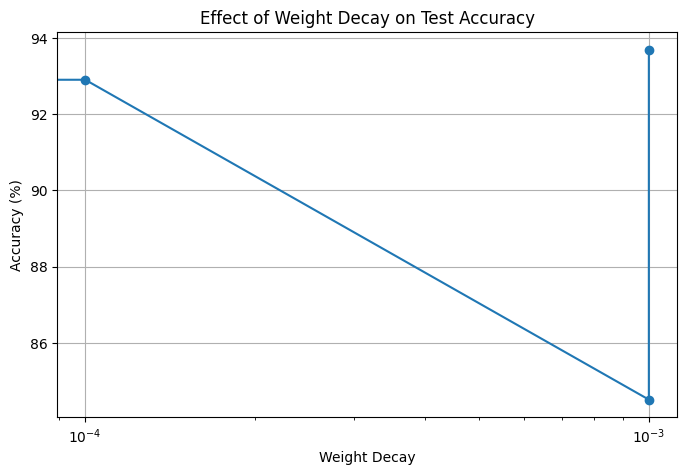

In [36]:
decay_values = [x[0] for x in decay_results]
accuracies = [x[1] for x in decay_results]

plt.figure(figsize=(8,5))
plt.plot(decay_values, accuracies, marker='o')
plt.title("Effect of Weight Decay on Test Accuracy")
plt.xlabel("Weight Decay")
plt.ylabel("Accuracy (%)")
plt.xscale('log')
plt.grid(True)
plt.show()


## **Optimizers**

In [37]:
optimizers = {
    "Adam": torch.optim.Adam,
    "SGD": torch.optim.SGD,
    "RMSprop": torch.optim.RMSprop
}

optimizer_results = []

for opt_name, opt_class in optimizers.items():
    print(f"🔄 Training with optimizer: {opt_name}")

    model = models.resnet18(pretrained=True)
    model.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(model.fc.in_features, num_classes)
    )

    optimizer = opt_class(model.parameters(), lr=0.001, weight_decay=1e-4)

    tag = f"Optimizer_{opt_name}"
    checkpoint_path = f"/kaggle/working/checkpoint_optimizer_{opt_name}.pth"
    train_model(
    model=model,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    writer=writer,
    tag=f"opt_{wd}",
    scheduler=None,
    epochs=5,
    checkpoint_path=checkpoint_path  
)

    model_path = f"/kaggle/working/best_model_optimizer_{opt_name}.pth"
    torch.save(model.state_dict(), model_path)
    acc, loss = evaluate_model_on_train(
    model=model,
    train_loader=train_loader,
    criterion=criterion,
    device=device,
    writer=writer,
    tag="OPTIMIZER_Eval",
    epoch=4
    )
    decay_results.append((wd, acc, loss))

    optimizer_results.append((opt_name, acc))
    print(f"✅ {opt_name} Accuracy: {acc:.2f}% , Loss: {loss:.4f}")


🔄 Training with optimizer: Adam

🔄 Epoch 1/5
  🧮 Batch 0: Loss = 2.1229, Accuracy = 25.00%
  🧮 Batch 10: Loss = 1.4972, Accuracy = 56.82%
  🧮 Batch 20: Loss = 1.1826, Accuracy = 56.70%
  🧮 Batch 30: Loss = 1.2516, Accuracy = 57.66%
  🧮 Batch 40: Loss = 0.9865, Accuracy = 59.98%
  🧮 Batch 50: Loss = 0.9920, Accuracy = 62.01%
  🧮 Batch 60: Loss = 1.2753, Accuracy = 63.17%
  🧮 Batch 70: Loss = 1.0796, Accuracy = 62.94%
  🧮 Batch 80: Loss = 0.7632, Accuracy = 64.31%
  🧮 Batch 90: Loss = 0.6384, Accuracy = 65.45%
  🧮 Batch 100: Loss = 0.9918, Accuracy = 65.97%
  🧮 Batch 110: Loss = 0.5429, Accuracy = 66.84%
  🧮 Batch 120: Loss = 0.4333, Accuracy = 67.95%
  🧮 Batch 130: Loss = 0.4606, Accuracy = 68.42%
  🧮 Batch 140: Loss = 0.9264, Accuracy = 68.64%
  🧮 Batch 150: Loss = 0.6871, Accuracy = 68.85%
  🧮 Batch 160: Loss = 0.7441, Accuracy = 69.37%
  🧮 Batch 170: Loss = 0.4785, Accuracy = 70.14%
  🧮 Batch 180: Loss = 0.3267, Accuracy = 70.65%
  🧮 Batch 190: Loss = 0.8047, Accuracy = 70.98%
  🧮 Ba

## **DROP Rates**

In [38]:
dropout_rates = [0.0, 0.3, 0.5]
dropout_results = []

for rate in dropout_rates:
    print(f"🔄 Training with dropout rate: {rate}")

    model = models.resnet18(pretrained=True)
    model.fc = nn.Sequential(
        nn.Dropout(rate),  # 🔁 only this changes
        nn.Linear(model.fc.in_features, num_classes)
    )

    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    tag = f"Dropout_{rate}"
    
    checkpoint_path = f"/kaggle/working/checkpoint_dropout_{rate}.pth"
    model_path = f"/kaggle/working/best_model_dropout_{rate}.pth"
    
    train_model(
    model=model,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    writer=writer,
    tag=f"DROP_{wd}",
    scheduler=None,
    epochs=5,
    checkpoint_path=checkpoint_path  # 👈 unique file for each setting
    )
    torch.save(model.state_dict(), model_path)
    acc, loss = evaluate_model_on_train(
    model=model,
    train_loader=train_loader,
    criterion=criterion,
    device=device,
    writer=writer,
    tag="DROPRATES_Eval",
    epoch=4
    )
    decay_results.append((wd, acc, loss))

    dropout_results.append((rate, acc))
    print(f"✅ Dropout {rate} Accuracy: {acc:.2f}% , Loss: {loss:.4f}")


🔄 Training with dropout rate: 0.0

🔄 Epoch 1/5
  🧮 Batch 0: Loss = 2.1313, Accuracy = 9.38%
  🧮 Batch 10: Loss = 1.1196, Accuracy = 51.70%
  🧮 Batch 20: Loss = 1.1878, Accuracy = 58.48%
  🧮 Batch 30: Loss = 0.6304, Accuracy = 63.31%
  🧮 Batch 40: Loss = 0.8244, Accuracy = 64.86%
  🧮 Batch 50: Loss = 0.9821, Accuracy = 66.48%
  🧮 Batch 60: Loss = 0.8846, Accuracy = 68.14%
  🧮 Batch 70: Loss = 0.8823, Accuracy = 68.49%
  🧮 Batch 80: Loss = 0.5700, Accuracy = 69.68%
  🧮 Batch 90: Loss = 0.7661, Accuracy = 70.67%
  🧮 Batch 100: Loss = 0.6884, Accuracy = 71.04%
  🧮 Batch 110: Loss = 0.5938, Accuracy = 71.82%
  🧮 Batch 120: Loss = 0.2608, Accuracy = 72.31%
  🧮 Batch 130: Loss = 0.5598, Accuracy = 72.73%
  🧮 Batch 140: Loss = 0.7558, Accuracy = 73.27%
  🧮 Batch 150: Loss = 0.4911, Accuracy = 73.70%
  🧮 Batch 160: Loss = 0.7479, Accuracy = 73.84%
  🧮 Batch 170: Loss = 1.1873, Accuracy = 74.14%
  🧮 Batch 180: Loss = 0.4030, Accuracy = 74.64%
  🧮 Batch 190: Loss = 0.6094, Accuracy = 74.84%
  🧮 B

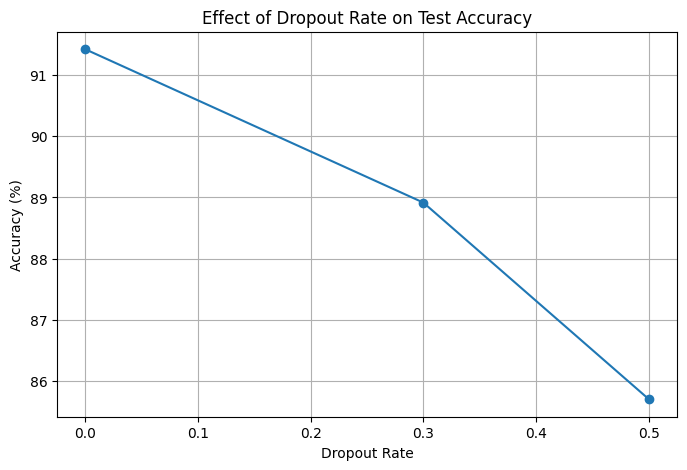

In [39]:
rates = [x[0] for x in dropout_results]
accs = [x[1] for x in dropout_results]

plt.figure(figsize=(8,5))
plt.plot(rates, accs, marker='o')
plt.title("Effect of Dropout Rate on Test Accuracy")
plt.xlabel("Dropout Rate")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()


## **Batch Size**

In [40]:
batch_sizes = [16, 32, 64]
batch_results = []

for bs in batch_sizes:
    print(f"\n🔄 Training with batch size: {bs}")

    # Create DataLoaders for this batch size
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

    model = models.resnet18(pretrained=True)
    model.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(model.fc.in_features, num_classes)
    )
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    tag = f"BatchSize_{bs}"

    checkpoint_path = f"/kaggle/working/checkpoint_batch_{bs}.pth"
    model_path = f"/kaggle/working/best_model_batch_{bs}.pth"

    # Train
    train_model(
        model=model,
        train_loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        writer=writer,
        tag=tag,
        scheduler=None,
        epochs=5,
        checkpoint_path=checkpoint_path
    )

    # Save model weights
    torch.save(model.state_dict(), model_path)

    # Evaluate
    acc, loss = evaluate_model_on_train(
        model=model,
        train_loader=train_loader,
        criterion=criterion,
        device=device,
        writer=writer,
        tag=f"{tag}_Eval",
        epoch=4
    )

    batch_results.append((bs, acc, loss))
    print(f"✅ Batch Size {bs} Accuracy: {acc:.2f}%, Loss: {loss:.4f}")



🔄 Training with batch size: 16

🔄 Epoch 1/5
  🧮 Batch 0: Loss = 2.2462, Accuracy = 12.50%
  🧮 Batch 10: Loss = 1.2835, Accuracy = 43.75%
  🧮 Batch 20: Loss = 2.2719, Accuracy = 44.35%
  🧮 Batch 30: Loss = 0.8552, Accuracy = 45.77%
  🧮 Batch 40: Loss = 1.7664, Accuracy = 47.26%
  🧮 Batch 50: Loss = 1.1597, Accuracy = 49.02%
  🧮 Batch 60: Loss = 1.2105, Accuracy = 50.61%
  🧮 Batch 70: Loss = 1.4378, Accuracy = 51.67%
  🧮 Batch 80: Loss = 1.1285, Accuracy = 53.24%
  🧮 Batch 90: Loss = 1.0971, Accuracy = 53.98%
  🧮 Batch 100: Loss = 1.5349, Accuracy = 54.58%
  🧮 Batch 110: Loss = 1.2724, Accuracy = 54.95%
  🧮 Batch 120: Loss = 1.2912, Accuracy = 55.48%
  🧮 Batch 130: Loss = 0.7651, Accuracy = 56.11%
  🧮 Batch 140: Loss = 1.1544, Accuracy = 56.47%
  🧮 Batch 150: Loss = 0.5815, Accuracy = 57.45%
  🧮 Batch 160: Loss = 0.7068, Accuracy = 58.23%
  🧮 Batch 170: Loss = 1.0507, Accuracy = 58.66%
  🧮 Batch 180: Loss = 0.9581, Accuracy = 58.91%
  🧮 Batch 190: Loss = 1.0861, Accuracy = 59.26%
  🧮 Ba

## **Number of Layers**

In [41]:
layer_configs = {
    "1-layer": lambda in_features: nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_features, num_classes)
    ),
    "2-layer": lambda in_features: nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_features, 256),
        nn.ReLU(),
        nn.Linear(256, num_classes)
    ),
    "3-layer": lambda in_features: nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, num_classes)
    )
}

layer_results = []

for name, classifier_factory in layer_configs.items():
    print(f"\n🔄 Training with {name}")

    model = models.resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = classifier_factory(in_features)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    tag = f"NumLayers_{name.replace('-', '')}"

    checkpoint_path = f"/kaggle/working/checkpoint_layers_{name.replace('-', '')}.pth"
    model_path = f"/kaggle/working/best_model_layers_{name.replace('-', '')}.pth"

    train_model(
        model=model,
        train_loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        writer=writer,
        tag=tag,
        scheduler=None,
        epochs=5,
        checkpoint_path=checkpoint_path
    )

    torch.save(model.state_dict(), model_path)

    acc, loss = evaluate_model_on_train(
        model=model,
        train_loader=train_loader,
        criterion=criterion,
        device=device,
        writer=writer,
        tag=f"{tag}_Eval",
        epoch=4
    )

    layer_results.append((name, acc, loss))
    print(f"✅ {name} Accuracy: {acc:.2f}%, Loss: {loss:.4f}")



🔄 Training with 1-layer

🔄 Epoch 1/5
  🧮 Batch 0: Loss = 1.9412, Accuracy = 25.00%
  🧮 Batch 10: Loss = 0.7230, Accuracy = 62.07%
  🧮 Batch 20: Loss = 0.6591, Accuracy = 66.67%
  🧮 Batch 30: Loss = 0.6153, Accuracy = 68.65%
  🧮 Batch 40: Loss = 0.5691, Accuracy = 70.54%
  🧮 Batch 50: Loss = 0.6388, Accuracy = 72.33%
  🧮 Batch 60: Loss = 0.6244, Accuracy = 73.23%
  🧮 Batch 70: Loss = 0.4517, Accuracy = 74.56%
  🧮 Batch 80: Loss = 0.6697, Accuracy = 75.68%
  🧮 Batch 90: Loss = 0.4191, Accuracy = 76.43%
  🧮 Batch 100: Loss = 0.8671, Accuracy = 76.95%
  🧮 Batch 110: Loss = 0.6654, Accuracy = 77.48%
  🧮 Batch 120: Loss = 0.4212, Accuracy = 78.05%
[NumLayers_1layer] ✅ Epoch 1 Complete — Loss: 81.6740, Accuracy: 78.51%
💾 Checkpoint saved at: /kaggle/working/checkpoint_layers_1layer.pth

🔄 Epoch 2/5
  🧮 Batch 0: Loss = 0.4573, Accuracy = 81.25%
  🧮 Batch 10: Loss = 0.2277, Accuracy = 86.65%
  🧮 Batch 20: Loss = 0.3266, Accuracy = 86.76%
  🧮 Batch 30: Loss = 0.3512, Accuracy = 87.90%
  🧮 Batch

## **Best Model**

In [42]:

# === Best hyperparameters ===
best_dropout = 0.3
best_lr = 0.001
best_weight_decay = 0.0
best_optimizer = optim.Adam
best_scheduler = StepLR
num_classes = 7



best_classifier = nn.Sequential(
    nn.Dropout(best_dropout),
    nn.Linear(512, 256),  
    nn.ReLU(),
    nn.Linear(256, num_classes)
)

In [43]:

model = models.resnet18(pretrained=True)
model.fc = best_classifier


optimizer = best_optimizer(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
scheduler = best_scheduler(optimizer, step_size=2, gamma=0.5)
checkpoint_path = f"/kaggle/working/checkpoint_Final_best_model_0.0.pth"
model_path = f"/kaggle/working/final_best_model.pth"

train_model(
    model=model,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    writer=writer,
    tag="Final_best_model_0.0",
    scheduler=scheduler,
    epochs=5,
    checkpoint_path=checkpoint_path
)

# === Save model ===
torch.save(model.state_dict(), model_path)
print("✅ Final model with best hyperparameters saved.")


🔄 Epoch 1/5
  🧮 Batch 0: Loss = 1.9410, Accuracy = 23.44%
  🧮 Batch 10: Loss = 0.8038, Accuracy = 60.37%
  🧮 Batch 20: Loss = 0.7089, Accuracy = 64.43%
  🧮 Batch 30: Loss = 0.7538, Accuracy = 67.34%
  🧮 Batch 40: Loss = 0.7086, Accuracy = 70.20%
  🧮 Batch 50: Loss = 0.9367, Accuracy = 71.60%
  🧮 Batch 60: Loss = 0.4539, Accuracy = 73.21%
  🧮 Batch 70: Loss = 0.7066, Accuracy = 74.01%
  🧮 Batch 80: Loss = 0.3941, Accuracy = 75.17%
  🧮 Batch 90: Loss = 0.3963, Accuracy = 76.10%
  🧮 Batch 100: Loss = 0.2747, Accuracy = 76.76%
  🧮 Batch 110: Loss = 0.5167, Accuracy = 77.25%
  🧮 Batch 120: Loss = 0.5228, Accuracy = 77.60%
[Final_best_model_0.0] ✅ Epoch 1 Complete — Loss: 83.9941, Accuracy: 77.97%
💾 Checkpoint saved at: /kaggle/working/checkpoint_Final_best_model_0.0.pth

🔄 Epoch 2/5
  🧮 Batch 0: Loss = 0.4328, Accuracy = 85.94%
  🧮 Batch 10: Loss = 0.3367, Accuracy = 85.51%
  🧮 Batch 20: Loss = 0.4695, Accuracy = 85.49%
  🧮 Batch 30: Loss = 0.2563, Accuracy = 85.28%
  🧮 Batch 40: Loss = 0.

## **Image Prediction Function**

In [44]:
def predict_image(model, image_path, transform, device, class_names):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        pred_class = class_names[predicted.item()]
    return pred_class


##**Example Usage to Predict New Image**

In [98]:
image_path = "/kaggle/input/sports-image-classification/dataset/test/91b5f8b7a9.jpg"
predicted_class = predict_image(model, image_path, train_transform, device, classes)
print(f"🧠 Predicted Class: {predicted_class}")


🧠 Predicted Class: Badminton


In [61]:
model.eval()
results = []

with torch.no_grad():
    for images, img_names in tqdm(test_loader):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_classes = [classes[i] for i in predicted.cpu().numpy()]

        for name, label in zip(img_names, predicted_classes):
            results.append({
                'image_ID': name,
                'predicted_label': label
            })

results_df = pd.DataFrame(results)
results_df.to_csv("test_predictions.csv", index=False)
print("✅ Saved predictions to test_predictions.csv")


100%|██████████| 65/65 [00:34<00:00,  1.91it/s]

✅ Saved predictions to test_predictions.csv


run tenserboard


In [105]:
!zip -r runs_logs.zip runs/


updating: runs/ (stored 0%)
updating: runs/20250502-194329/ (stored 0%)
updating: runs/20250502-194329/events.out.tfevents.1746215009.44254443f12e.31.0 (deflated 66%)


In [100]:
%load_ext tensorboard
%tensorboard --logdir runs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 567), started 0:04:32 ago. (Use '!kill 567' to kill it.)

<IPython.core.display.Javascript object>